In [1]:
# 第一个代码块：导入必要的库和配置类
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import math
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
# 在开头导入部分添加
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time

# 更新Config类
class Config:
    def __init__(self):
        # 增加模型容量
        self.hidden_size = 128
        self.num_heads = 8
        self.num_layers = 3
        self.dropout = 0.2
        self.window_size = 7
        
        # 调整训练参数
        self.batch_size = 64
        self.max_epochs = 5
        self.learning_rate = 2e-4
        self.warmup_steps = 200
        
        # 调整损失权重
        self.alpha = 0.5
        self.beta = 0.3
        self.gamma = 0.2
        
        self.lambda1 = 0.005
        self.lambda2 = 0.005
        self.lambda3 = 0.005

In [2]:
# 第二个代码块：模型定义
class MarkovTransitionModule(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.window_size = config.window_size
        self.hidden_size = config.hidden_size
        
        self.conv = nn.Conv1d(config.hidden_size, config.hidden_size, 
                             kernel_size=config.window_size,
                             padding=config.window_size//2)
        self.transition = nn.Linear(config.hidden_size, config.hidden_size)
        
    def forward(self, x):
        batch_size, seq_len, hidden_size = x.size()
        
        # 计算局部转移特征
        x_conv = self.conv(x.transpose(1, 2)).transpose(1, 2)
        
        # 计算转移矩阵
        transition_logits = torch.matmul(self.transition(x), x.transpose(1, 2))
        transition_probs = torch.softmax(transition_logits, dim=-1)
        
        return transition_probs, x_conv

class EnhancedAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_heads = config.num_heads
        self.hidden_size = config.hidden_size
        self.head_dim = config.hidden_size // config.num_heads
        
        self.q_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.k_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.v_proj = nn.Linear(config.hidden_size, config.hidden_size)
        
        self.pos_proj = nn.Linear(config.hidden_size, config.hidden_size)
        
        self.alpha = nn.Parameter(torch.tensor(0.4))
        self.beta = nn.Parameter(torch.tensor(0.3))
        self.gamma = nn.Parameter(torch.tensor(0.3))
        
        self.out_proj = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x, markov_probs, pos_enc):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 处理位置编码
        pos = self.pos_proj(pos_enc)
        pos = pos.expand(batch_size, -1, -1)
        
        # 多头注意力处理
        Q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # 传统注意力分数
        scale = math.sqrt(self.head_dim)
        traditional_attn = torch.matmul(Q, K.transpose(-2, -1)) / scale
        traditional_attn = F.softmax(traditional_attn, dim=-1)
        
        # 位置注意力分数
        P = self.pos_proj(pos).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        position_attn = torch.matmul(Q, P.transpose(-2, -1)) / scale
        
        # 调整markov_probs的维度
        markov_probs = markov_probs.unsqueeze(1).expand(-1, self.num_heads, -1, -1)
        
        # 融合注意力分数
        attention_score = (
            self.alpha * traditional_attn +
            self.beta * markov_probs +
            self.gamma * position_attn
        )
        
        # attention_probs = F.softmax(attention_score, dim=-1)
        # attention_probs = self.dropout(attention_score)
        
        # 计算输出
        context = torch.matmul(attention_score, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)
        output = self.out_proj(context)
        
        return output, attention_score

# 修改 MarkovTransformer 类的 forward 方法
class MarkovTransformer(nn.Module):
    def __init__(self, config, num_classes):
        super().__init__()
        self.config = config
        
        # 修改嵌入维度，增加表达能力
        # self.embedding = nn.Linear(28, config.hidden_size * 2)
        self.embedding = nn.Linear(28, config.hidden_size)
        self.dim_reduce = nn.Linear(config.hidden_size * 2, config.hidden_size)
        
        # 添加位置编码
        self.pos_encoder = nn.Parameter(torch.zeros(1, 28, config.hidden_size))
        nn.init.normal_(self.pos_encoder, mean=0, std=0.02)
        
        self.markov_module = MarkovTransitionModule(config)
        self.attention = EnhancedAttention(config)
        
        # 添加更多层次的特征提取
        self.feature_extraction = nn.Sequential(
            nn.LayerNorm(config.hidden_size),
            nn.Linear(config.hidden_size, config.hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_size * 2, config.hidden_size)
        )
        
        self.layer_norm1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm2 = nn.LayerNorm(config.hidden_size)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_size * 4, config.hidden_size)
        )
        
        # 改进分类头
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_size, num_classes)
        )
        
        # 初始化参数
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        
        # 增强的特征提取
        x = self.embedding(x)
        # x = self.dim_reduce(x)
        # x = self.feature_extraction(x)
        
        # 添加位置编码
        x = x + self.pos_encoder
        
        # Markov和注意力机制
        markov_probs, local_features = self.markov_module(x)
        attention_output, attention_weights = self.attention(x, markov_probs, self.pos_encoder)
        
        # 残差连接和特征融合
        # x = self.layer_norm1(x + attention_output + local_features)
        x = self.layer_norm1(x + attention_output)
        x = self.layer_norm2(x + self.feed_forward(x))
        
        # 全局池化和分类
        x = x.mean(dim=1)
        output = self.classifier(x)
        
        return output, attention_weights, markov_probs


In [3]:
# 第三个代码块：基线模型
class VanillaTransformer(nn.Module):
    def __init__(self, config, num_classes):
        super().__init__()
        self.config = config
        
        # 修改嵌入层
        self.embedding = nn.Linear(28, config.hidden_size)  # 每个时间步是28维
        
        # 位置编码
        self.pos_encoder = nn.Parameter(torch.zeros(1, 28, config.hidden_size))
        nn.init.normal_(self.pos_encoder, mean=0, std=0.02)
        
        # Transformer编码器层
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.hidden_size,
            nhead=config.num_heads,
            dim_feedforward=config.hidden_size * 4,
            dropout=config.dropout,
            batch_first=True
        )
        
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=config.num_layers
        )
        
        # 分类头
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        
        # 初始化参数
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, x):
        # x shape: (batch_size, 784)
        batch_size = x.size(0)
        
        # 重塑为 (batch_size, 28, 28)
        x = x.view(batch_size, 28, 28)
        
        # 对每个时间步进行特征提取
        x = self.embedding(x)  # (batch_size, 28, hidden_size)
        
        # 添加位置编码
        x = x + self.pos_encoder
        
        # Transformer处理
        x = self.transformer(x)
        
        # 全局池化
        x = x.mean(dim=1)  # (batch_size, hidden_size)
        
        # 分类
        output = self.classifier(x)
        
        return output


class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        if len(x.shape) == 2:  # 如果输入是展平的
            x = x.view(-1, 1, 28, 28)
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# 第四个代码块：数据加载和处理
def load_mnist_data(batch_size, sample_size=None):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True,
                                 transform=transform)
    test_dataset = datasets.MNIST('./data', train=False,
                                transform=transform)
    
    if sample_size is not None:
        train_indices = torch.randperm(len(train_dataset))[:sample_size]
        test_indices = torch.randperm(len(test_dataset))[:sample_size//6]
        
        train_dataset = Subset(train_dataset, train_indices)
        test_dataset = Subset(test_dataset, test_indices)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False)
    
    return train_loader, test_loader

In [5]:
# 第五个代码块：训练和评估函数
class ModelEvaluator:
    @staticmethod
    def calculate_metrics(y_true, y_pred):
        # 计算各类指标
        accuracy = 100 * (y_true == y_pred).sum() / len(y_true)
        precision = 100 * precision_score(y_true, y_pred, average='macro')
        recall = 100 * recall_score(y_true, y_pred, average='macro')
        f1 = 100 * f1_score(y_true, y_pred, average='macro')
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, model_name):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

class ModelTrainer:
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        self.model.to(device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(model.parameters(), lr=config.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=config.learning_rate,
            epochs=config.max_epochs,
            steps_per_epoch=len(train_loader)
        )
    
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):
            data, target = data.to(self.device), target.to(self.device)
            
            if len(data.shape) == 4:  # MNIST images
                data = data.squeeze(1)  # Remove channel dimension
                data = data.view(data.size(0), -1)  # Flatten
            
            self.optimizer.zero_grad()
            
            if isinstance(self.model, (VanillaTransformer, CNN)):
                output = self.model(data)
                loss = self.criterion(output, target)
            else:  # MarkovTransformer
                output, attention_weights, markov_probs = self.model(data)
                
                # 主任务损失
                task_loss = self.criterion(output, target)
                
                # 正则化损失
                markov_reg = -torch.mean(torch.sum(markov_probs * 
                                               torch.log(markov_probs + 1e-10), dim=-1))
                
                # 注意力稀疏性损失
                attention_sparsity = torch.mean(torch.sum(
                    attention_weights.mean(dim=1), dim=-1))
                
                # 一致性损失
                consistency_loss = F.mse_loss(
                    attention_weights.mean(dim=1),
                    markov_probs
                )
                
                # 动态权重
                epoch_progress = batch_idx / len(train_loader)
                lambda_schedule = max(0.1, 1 - epoch_progress)
                
                # 总损失
                loss = (task_loss + 
                       self.config.lambda1 * markov_reg * lambda_schedule +
                       self.config.lambda2 * attention_sparsity * lambda_schedule +
                       self.config.lambda3 * consistency_loss * lambda_schedule)   # A+B+C+D
                # loss = (task_loss + 
                #        self.config.lambda1 * markov_reg * lambda_schedule) #A+B
                
                # loss = (task_loss + 
                #        self.config.lambda1 * markov_reg * lambda_schedule +
                #        self.config.lambda2 * attention_sparsity * lambda_schedule )   # A+B+C
                
            
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer.step()
            self.scheduler.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy
    
    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                if len(data.shape) == 4:
                    data = data.squeeze(1)
                    data = data.view(data.size(0), -1)
                
                if isinstance(self.model, (VanillaTransformer, CNN)):
                    output = self.model(data)
                    loss = self.criterion(output, target)
                else:
                    output, attention_weights, markov_probs = self.model(data)
                    loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        
        avg_loss = total_loss / len(test_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy

def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    all_preds = []
    all_targets = []
    total_inference_time = 0
    num_samples = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if len(data.shape) == 4:
                data = data.squeeze(1)
                data = data.view(data.size(0), -1)
            
            # 记录推理开始时间
            start_time = time.time()
            
            if isinstance(model, MarkovTransformer):
                output, _, _ = model(data)
            else:
                output = model(data)
            
            # 计算推理时间
            inference_time = time.time() - start_time
            total_inference_time += inference_time
            num_samples += data.size(0)
            
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # 计算平均推理时间（每个样本）
    avg_inference_time = (total_inference_time / num_samples) * 1000  # 转换为毫秒
    
    # 转换为numpy数组
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # 计算指标
    metrics = ModelEvaluator.calculate_metrics(all_targets, all_preds)
    metrics['inference_time'] = avg_inference_time
    
    # 绘制混淆矩阵
    ModelEvaluator.plot_confusion_matrix(all_targets, all_preds, model_name)
    
    return metrics

# 实验运行部分保持不变，只需修改最后的结果打印部分




Using device: cuda

Training MARKOV model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\335746803.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 2.1870, Train Acc: 21.27%
Test Loss: 1.7617, Test Acc: 39.20%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 1.5474, Train Acc: 48.47%
Test Loss: 1.0271, Test Acc: 70.70%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.7341, Train Acc: 77.55%
Test Loss: 0.4604, Test Acc: 85.20%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.4680, Train Acc: 86.25%
Test Loss: 0.3688, Test Acc: 88.50%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.4133, Train Acc: 87.72%
Test Loss: 0.3496, Test Acc: 88.60%

Final Evaluation for MARKOV:


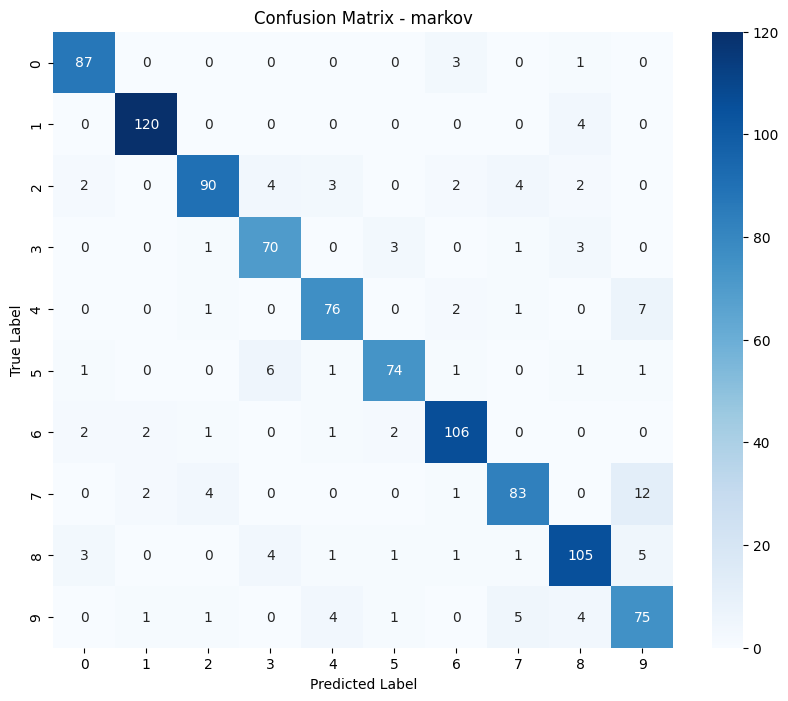


Training TRANSFORMER model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\335746803.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/94 [00:00<?, ?it/s]

D:\conda\envs\mouse\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/5:
Train Loss: 2.1075, Train Acc: 25.68%
Test Loss: 1.5417, Test Acc: 47.60%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 1.2954, Train Acc: 57.00%
Test Loss: 0.9043, Test Acc: 71.10%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.8363, Train Acc: 73.22%
Test Loss: 0.6621, Test Acc: 78.30%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.6771, Train Acc: 78.37%
Test Loss: 0.5958, Test Acc: 80.50%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.6155, Train Acc: 81.02%
Test Loss: 0.5797, Test Acc: 81.30%

Final Evaluation for TRANSFORMER:


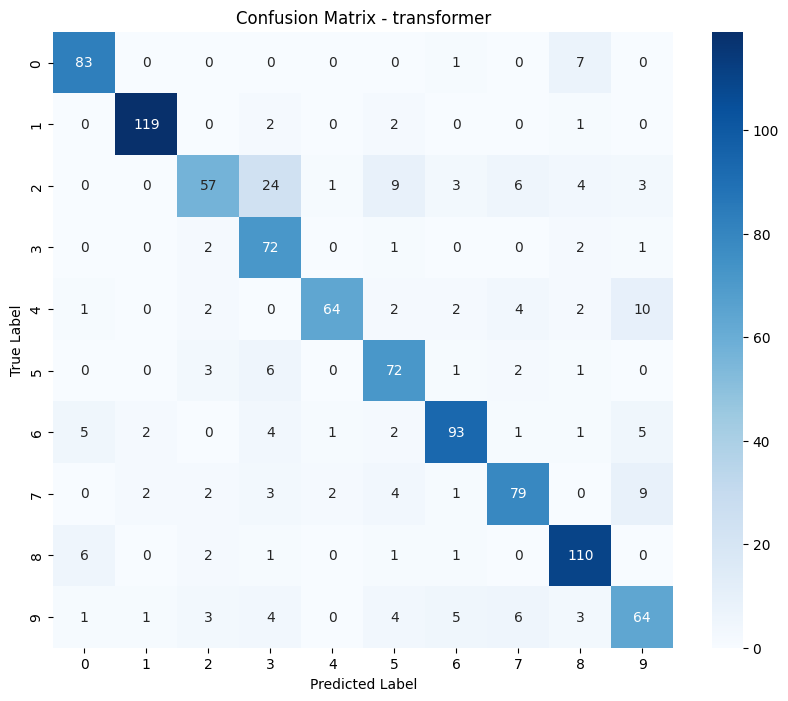


Training CNN model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\335746803.py:50: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.9217, Train Acc: 44.22%
Test Loss: 0.8480, Test Acc: 83.70%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.5238, Train Acc: 84.57%
Test Loss: 0.3540, Test Acc: 90.00%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.2956, Train Acc: 90.62%
Test Loss: 0.2042, Test Acc: 94.70%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.2100, Train Acc: 93.70%
Test Loss: 0.1716, Test Acc: 95.30%


  0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.1799, Train Acc: 94.82%
Test Loss: 0.1680, Test Acc: 95.30%

Final Evaluation for CNN:


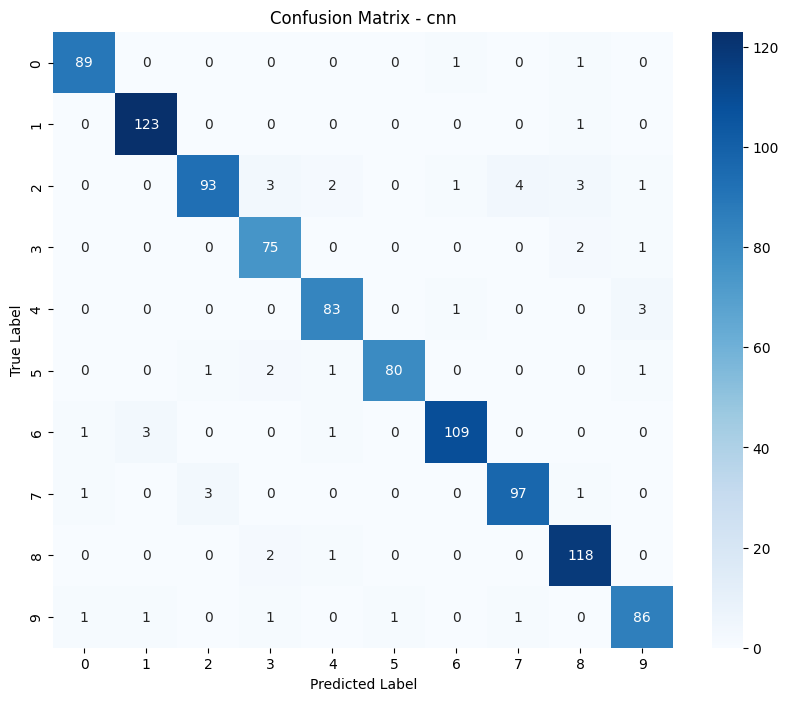

In [6]:
# 第六个代码块：实验运行
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 配置参数
config = Config()
sample_size = 6000  # 可以调整样本量

# 加载数据
train_loader, test_loader = load_mnist_data(config.batch_size, sample_size)

# 创建模型
models = {
    'markov': MarkovTransformer(config, num_classes=10),
    'transformer': VanillaTransformer(config, num_classes=10),
    'cnn': CNN(num_classes=10)
}

# 存储结果
results = {}
history = {name: {'train_loss': [], 'train_acc': [], 
                 'test_loss': [], 'test_acc': []} 
          for name in models.keys()}

# 训练和评估每个模型
for model_name, model in models.items():
    print(f"\nTraining {model_name.upper()} model...")
    trainer = ModelTrainer(model, config, device)
    
    for epoch in range(config.max_epochs):
        train_loss, train_acc = trainer.train_epoch(train_loader)
        test_loss, test_acc = trainer.evaluate(test_loader)
        
        # 记录历史
        history[model_name]['train_loss'].append(train_loss)
        history[model_name]['train_acc'].append(train_acc)
        history[model_name]['test_loss'].append(test_loss)
        history[model_name]['test_acc'].append(test_acc)
        
        print(f'Epoch {epoch+1}/{config.max_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # 最终评估
    print(f"\nFinal Evaluation for {model_name.upper()}:")
    metrics = evaluate_model(model, test_loader, device, model_name)
    results[model_name] = {
        'final_acc': history[model_name]['test_acc'][-1],
        'best_acc': max(history[model_name]['test_acc']),
        'avg_acc': sum(history[model_name]['test_acc'][-3:]) / 3,
        'metrics': metrics
    }



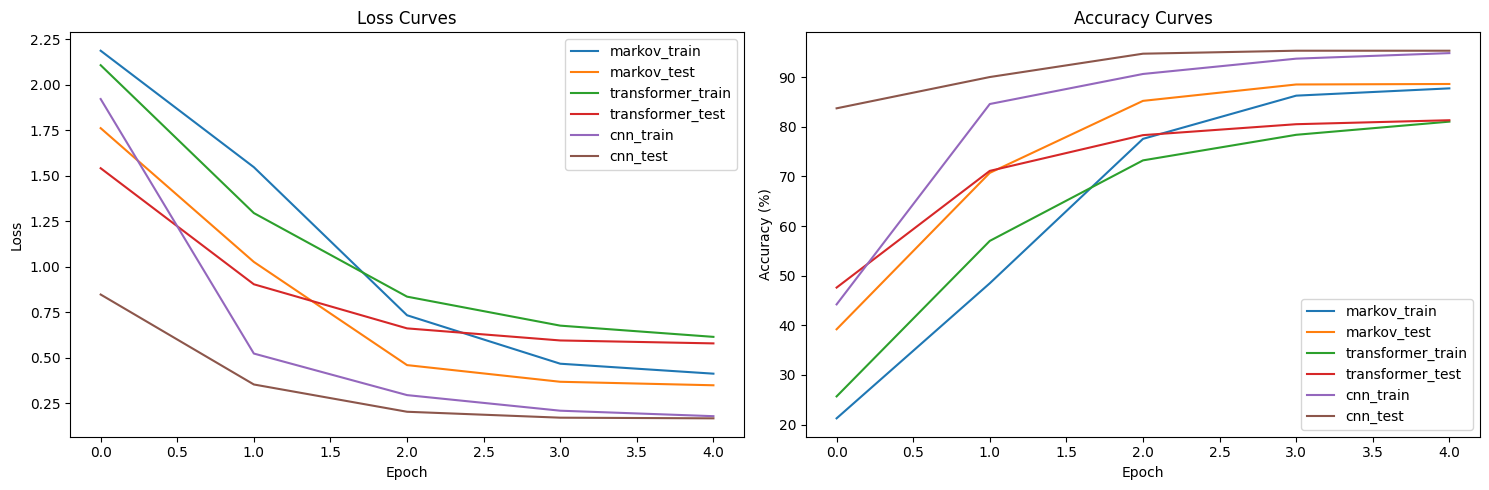

In [7]:
# 绘制训练曲线
plt.figure(figsize=(15, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
for model_name in models.keys():
    plt.plot(history[model_name]['train_loss'], label=f'{model_name}_train')
    plt.plot(history[model_name]['test_loss'], label=f'{model_name}_test')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
for model_name in models.keys():
    plt.plot(history[model_name]['train_acc'], label=f'{model_name}_train')
    plt.plot(history[model_name]['test_acc'], label=f'{model_name}_test')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()



In [8]:

# 打印详细结果
print("\nDetailed Results:")
for model_name, result in results.items():
    print(f"\n{model_name.upper()}:")
    print(f"  Final Accuracy: {result['final_acc']:.2f}%")
    print(f"  Best Accuracy: {result['best_acc']:.2f}%")
    print(f"  Average Accuracy (last 3): {result['avg_acc']:.2f}%")
    print(f"  Precision: {result['metrics']['precision']:.2f}%")
    print(f"  Recall: {result['metrics']['recall']:.2f}%")
    print(f"  F1 Score: {result['metrics']['f1']:.2f}%")
    print(f"  Average Inference Time: {result['metrics']['inference_time']:.2f} ms/sample")



Detailed Results:

MARKOV:
  Final Accuracy: 88.60%
  Best Accuracy: 88.60%
  Average Accuracy (last 3): 87.43%
  Precision: 88.37%
  Recall: 88.42%
  F1 Score: 88.33%
  Average Inference Time: 0.02 ms/sample

TRANSFORMER:
  Final Accuracy: 81.30%
  Best Accuracy: 81.30%
  Average Accuracy (last 3): 80.03%
  Precision: 81.42%
  Recall: 81.13%
  F1 Score: 80.51%
  Average Inference Time: 0.01 ms/sample

CNN:
  Final Accuracy: 95.30%
  Best Accuracy: 95.30%
  Average Accuracy (last 3): 95.10%
  Precision: 95.25%
  Recall: 95.23%
  F1 Score: 95.20%
  Average Inference Time: 0.00 ms/sample


In [9]:
# 添加新的模型类定义
class TransformerXL(nn.Module):
    def __init__(self, config, num_classes=10):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.mem_len = 16
        
        self.embedding = nn.Linear(28, config.hidden_size)
        self.pos_emb = nn.Parameter(torch.zeros(1, 28 + self.mem_len, config.hidden_size))
        nn.init.normal_(self.pos_emb, mean=0, std=0.02)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.hidden_size,
            nhead=config.num_heads,
            dim_feedforward=config.hidden_size * 4,
            dropout=config.dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, config.num_layers)
        
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.memory = None
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        x = self.embedding(x)
        
        if self.memory is None or self.memory.size(0) != batch_size:
            self.memory = torch.zeros(batch_size, self.mem_len, self.hidden_size).to(x.device)
        
        extended_input = torch.cat([self.memory, x], dim=1)
        extended_input = extended_input + self.pos_emb
        
        with torch.no_grad():
            self.memory = x[:, -self.mem_len:, :].detach()
        
        output = self.transformer(extended_input)
        output = output[:, -28:, :].mean(dim=1)
        return self.classifier(output)

class LocalAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, window_size, dropout):
        super().__init__()
        self.window_size = window_size
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        
    def forward(self, x):
        B, L, D = x.shape
        pad_size = (self.window_size - L % self.window_size) % self.window_size
        if pad_size > 0:
            x = F.pad(x, (0, 0, 0, pad_size))
        
        windows = x.unfold(1, self.window_size, self.window_size)
        windows = windows.reshape(-1, self.window_size, D)
        
        attended, _ = self.attention(windows, windows, windows)
        attended = attended.reshape(B, -1, D)[:, :L, :]
        
        x = x[:, :L, :] + attended
        x = self.norm1(x)
        
        x = x + self.feed_forward(x)
        x = self.norm2(x)
        
        return x

class LocalAttentionTransformer(nn.Module):
    def __init__(self, config, num_classes=10):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.window_size = 7
        
        self.embedding = nn.Linear(28, config.hidden_size)
        self.pos_embedding = nn.Parameter(torch.zeros(1, 28, config.hidden_size))
        
        self.layers = nn.ModuleList([
            LocalAttentionLayer(config.hidden_size, config.num_heads, self.window_size, config.dropout)
            for _ in range(config.num_layers)
        ])
        
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        x = self.embedding(x)
        x = x + self.pos_embedding
        
        for layer in self.layers:
            x = layer(x)
        
        x = x.mean(dim=1)
        return self.classifier(x)

class PerformerLayer(nn.Module):
    def __init__(self, hidden_size, num_features, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_features = num_features
        
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        
        self.random_projections = nn.Parameter(
            torch.randn(hidden_size, num_features) / math.sqrt(num_features)
        )
        
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size)
        )
        
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)
        
        q_feature = torch.exp(torch.matmul(q, self.random_projections))
        k_feature = torch.exp(torch.matmul(k, self.random_projections))
        
        kv = torch.matmul(k_feature.transpose(-2, -1), v)
        qkv = torch.matmul(q_feature, kv)
        
        normalizer = torch.matmul(q_feature, k_feature.sum(dim=1).unsqueeze(-1))
        output = qkv / (normalizer + 1e-6)
        
        x = x + self.dropout(output)
        x = self.norm1(x)
        
        x = x + self.feed_forward(x)
        x = self.norm2(x)
        
        return x

class Performer(nn.Module):
    def __init__(self, config, num_classes=10):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_features = 256
        
        self.embedding = nn.Linear(28, config.hidden_size)
        self.pos_embedding = nn.Parameter(torch.zeros(1, 28, config.hidden_size))
        
        self.layers = nn.ModuleList([
            PerformerLayer(config.hidden_size, self.num_features, config.dropout)
            for _ in range(config.num_layers)
        ])
        
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        x = self.embedding(x)
        x = x + self.pos_embedding
        
        for layer in self.layers:
            x = layer(x)
        
        x = x.mean(dim=1)
        return self.classifier(x)

class MarkovTransformerXL(TransformerXL):
    def __init__(self, config, num_classes=10):
        super().__init__(config, num_classes)
        self.markov_module = MarkovTransitionModule(config)
        self.enhanced_attention = EnhancedAttention(config)
        
        # 修改位置编码的维度
        self.pos_emb = nn.Parameter(torch.zeros(1, 44, config.hidden_size))  # 28 + 16 (mem_len)
        nn.init.normal_(self.pos_emb, mean=0, std=0.02)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        x = self.embedding(x)  # [batch_size, 28, hidden_size]
        
        # Markov转换
        original_markov_probs, local_features = self.markov_module(x)  # [batch_size, 28, 28]
        
        # 初始化或调整memory大小
        if self.memory is None or self.memory.size(0) != batch_size:
            self.memory = torch.zeros(batch_size, self.mem_len, self.hidden_size).to(x.device)
        
        # 连接memory和当前输入
        extended_input = torch.cat([self.memory, x], dim=1)  # [batch_size, 44, hidden_size]
        
        # 扩展markov_probs以匹配extended_input的大小
        padding = torch.zeros(batch_size, self.mem_len, 28).to(x.device)
        extended_markov_probs = torch.cat([padding, original_markov_probs], dim=1)  # [batch_size, 44, 28]
        
        # 进一步扩展markov_probs的最后一个维度
        padding_right = torch.zeros(batch_size, 44, self.mem_len).to(x.device)
        extended_markov_probs = torch.cat([extended_markov_probs, padding_right], dim=2)  # [batch_size, 44, 44]
        
        # 增强注意力处理
        enhanced_output, attention_weights = self.enhanced_attention(
            extended_input, 
            extended_markov_probs,  # 现在是 [batch_size, 44, 44]
            self.pos_emb
        )
        
        # 更新memory
        with torch.no_grad():
            self.memory = x[:, -self.mem_len:, :].detach()
        
        # Transformer处理
        output = self.transformer(enhanced_output)
        
        # 只使用最后28个时间步的输出进行分类
        output = output[:, -28:, :].mean(dim=1)
        output = self.classifier(output)
        
        # 返回时只返回与原始序列长度对应的注意力权重
        attention_weights = attention_weights[:, :, -28:, -28:]
        
        return output, attention_weights, original_markov_probs

def evaluate_model(model, test_loader, device, model_name):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if len(data.shape) == 4:
                data = data.squeeze(1)
                data = data.view(data.size(0), -1)
            
            # 检查是否是Markov类型的模型
            is_markov_model = isinstance(model, (MarkovTransformer, MarkovTransformerXL, 
                                               MarkovLocalAttentionTransformer, MarkovPerformer))
            
            if is_markov_model:
                output, _, _ = model(data)
                pred = output.argmax(dim=1)
            else:
                output = model(data)
                pred = output.argmax(dim=1)
            
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # 转换为numpy数组
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    # 计算指标
    metrics = {
        'precision': precision_score(all_targets, all_preds, average='macro'),
        'recall': recall_score(all_targets, all_preds, average='macro'),
        'f1': f1_score(all_targets, all_preds, average='macro'),
        'accuracy': (all_targets == all_preds).mean()
    }
    
    # 绘制混淆矩阵
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return metrics

class MarkovLocalAttentionTransformer(LocalAttentionTransformer):
    def __init__(self, config, num_classes=10):
        super().__init__(config, num_classes)
        self.markov_module = MarkovTransitionModule(config)
        self.enhanced_attention = EnhancedAttention(config)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        x = self.embedding(x)
        
        # Markov转换和增强注意力
        markov_probs, local_features = self.markov_module(x)
        x, attention_weights = self.enhanced_attention(x, markov_probs, self.pos_embedding)
        
        for layer in self.layers:
            x = layer(x)
        
        x = x.mean(dim=1)
        return self.classifier(x), attention_weights, markov_probs

class MarkovPerformer(Performer):
    def __init__(self, config, num_classes=10):
        super().__init__(config, num_classes)
        self.markov_module = MarkovTransitionModule(config)
        self.enhanced_attention = EnhancedAttention(config)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28, 28)
        x = self.embedding(x)
        
        # Markov转换和增强注意力
        markov_probs, local_features = self.markov_module(x)
        x, attention_weights = self.enhanced_attention(x, markov_probs, self.pos_embedding)
        
        for layer in self.layers:
            x = layer(x)
        
        x = x.mean(dim=1)
        return self.classifier(x), attention_weights, markov_probs



In [10]:
class ModelTrainer:
    def __init__(self, model, config, device):
        self.model = model
        self.config = config
        self.device = device
        self.model.to(device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = AdamW(model.parameters(), lr=config.learning_rate)
        self.scheduler = None
    
    def train_epoch(self, train_loader):
        if self.scheduler is None:
            self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
                self.optimizer,
                max_lr=self.config.learning_rate,
                epochs=self.config.max_epochs,
                steps_per_epoch=len(train_loader)
            )
        
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):
            data, target = data.to(self.device), target.to(self.device)
            
            if len(data.shape) == 4:
                data = data.squeeze(1)
                data = data.view(data.size(0), -1)
            
            self.optimizer.zero_grad()
            
            # 检查是否是Markov类型的模型
            is_markov_model = isinstance(self.model, (MarkovTransformer, MarkovTransformerXL, 
                                                    MarkovLocalAttentionTransformer, MarkovPerformer))
            
            if is_markov_model:
                output, attention_weights, markov_probs = self.model(data)
                task_loss = self.criterion(output, target)
                
                # 确保维度匹配
                attention_mean = attention_weights.mean(dim=1)  # [batch_size, seq_len, seq_len]
                
                # 计算各种损失
                markov_reg = -torch.mean(torch.sum(markov_probs * 
                                               torch.log(markov_probs + 1e-10), dim=-1))
                attention_sparsity = torch.mean(torch.sum(attention_mean, dim=-1))
                
                # 裁剪attention_mean以匹配markov_probs的维度
                attention_mean = attention_mean[:, :markov_probs.size(1), :markov_probs.size(2)]
                consistency_loss = F.mse_loss(attention_mean, markov_probs)
                
                epoch_progress = batch_idx / len(train_loader)
                lambda_schedule = max(0.1, 1 - epoch_progress)
                
                # 总损失
                loss = (task_loss + 
                       self.config.lambda1 * markov_reg * lambda_schedule +
                       self.config.lambda2 * attention_sparsity * lambda_schedule +
                       self.config.lambda3 * consistency_loss * lambda_schedule)   # A+B+C+D
                # loss = (task_loss + 
                #        self.config.lambda1 * markov_reg * lambda_schedule) #A+B
                
                # loss = (task_loss + 
                #        self.config.lambda1 * markov_reg * lambda_schedule +
                #        self.config.lambda2 * attention_sparsity * lambda_schedule )   # A+B+C
            else:
                output = self.model(data)
                loss = self.criterion(output, target)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
        
        avg_loss = total_loss / len(train_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy

    def evaluate(self, test_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                if len(data.shape) == 4:
                    data = data.squeeze(1)
                    data = data.view(data.size(0), -1)
                
                # 检查是否是Markov类型的模型
                is_markov_model = isinstance(self.model, (MarkovTransformer, MarkovTransformerXL, 
                                                        MarkovLocalAttentionTransformer, MarkovPerformer))
                
                if is_markov_model:
                    output, _, _ = self.model(data)
                else:
                    output = self.model(data)
                
                loss = self.criterion(output, target)
                
                total_loss += loss.item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
        
        avg_loss = total_loss / len(test_loader)
        accuracy = 100. * correct / total
        
        return avg_loss, accuracy

Using device: cuda

Training MARKOV model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.4285, Train Acc: 51.14%
Test Loss: 0.3044, Test Acc: 90.66%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.2522, Train Acc: 92.30%
Test Loss: 0.1462, Test Acc: 95.22%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1550, Train Acc: 95.30%
Test Loss: 0.1191, Test Acc: 96.15%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.1171, Train Acc: 96.48%
Test Loss: 0.0944, Test Acc: 96.93%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.1000, Train Acc: 97.02%
Test Loss: 0.0910, Test Acc: 97.08%

Final Evaluation for MARKOV:


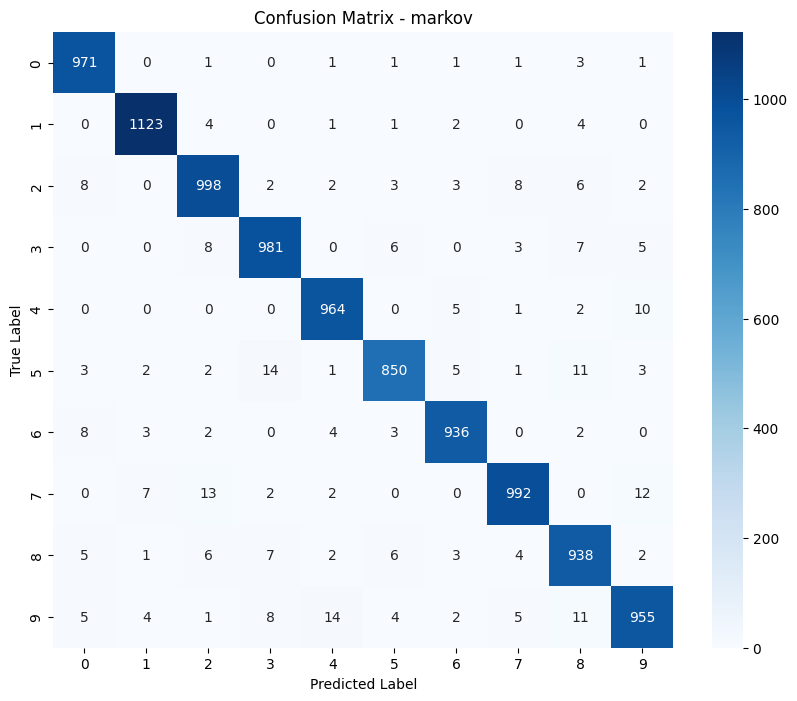


Training TRANSFORMER model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.3292, Train Acc: 54.75%
Test Loss: 0.5908, Test Acc: 80.66%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.3637, Train Acc: 88.45%
Test Loss: 0.2217, Test Acc: 93.13%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1540, Train Acc: 95.17%
Test Loss: 0.0947, Test Acc: 97.12%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.0956, Train Acc: 97.03%
Test Loss: 0.0698, Test Acc: 97.83%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0713, Train Acc: 97.70%
Test Loss: 0.0657, Test Acc: 98.00%

Final Evaluation for TRANSFORMER:


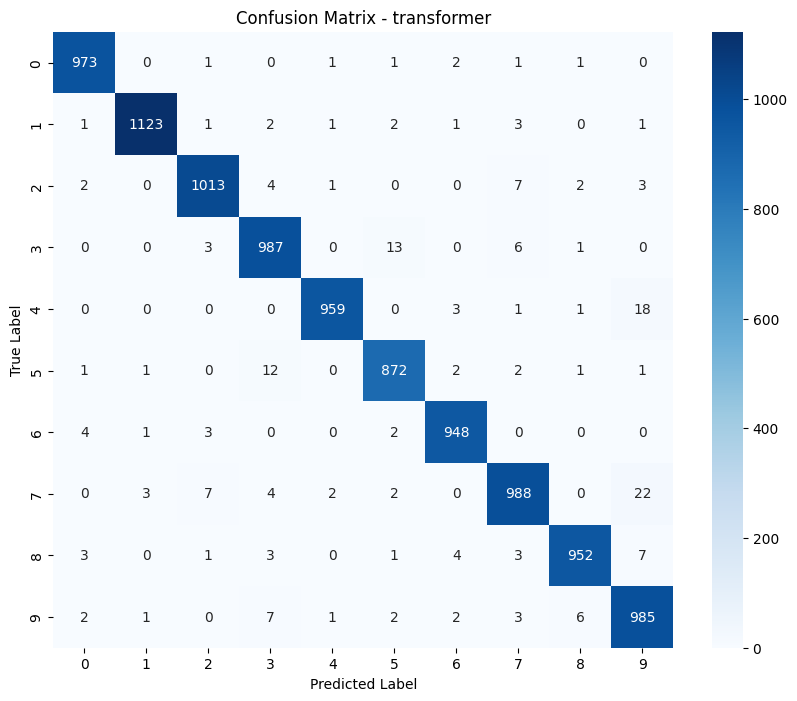


Training CNN model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 0.8717, Train Acc: 78.78%
Test Loss: 0.1383, Test Acc: 95.79%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.1095, Train Acc: 96.66%
Test Loss: 0.0464, Test Acc: 98.38%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.0604, Train Acc: 98.15%
Test Loss: 0.0365, Test Acc: 98.70%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.0420, Train Acc: 98.69%
Test Loss: 0.0285, Test Acc: 98.94%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0325, Train Acc: 99.02%
Test Loss: 0.0269, Test Acc: 99.02%

Final Evaluation for CNN:


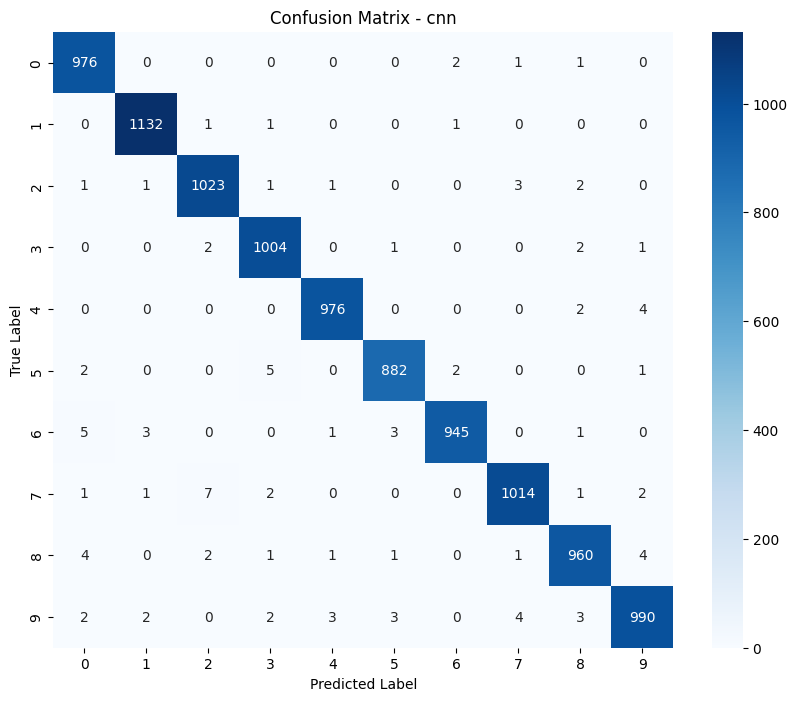


Training TRANSFORMER_XL model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.7061, Train Acc: 41.48%
Test Loss: 0.9341, Test Acc: 68.07%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.4362, Train Acc: 86.51%
Test Loss: 0.2019, Test Acc: 93.50%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1738, Train Acc: 94.62%
Test Loss: 0.1175, Test Acc: 96.41%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.1152, Train Acc: 96.47%
Test Loss: 0.0867, Test Acc: 97.36%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0899, Train Acc: 97.28%
Test Loss: 0.0839, Test Acc: 97.47%

Final Evaluation for TRANSFORMER_XL:


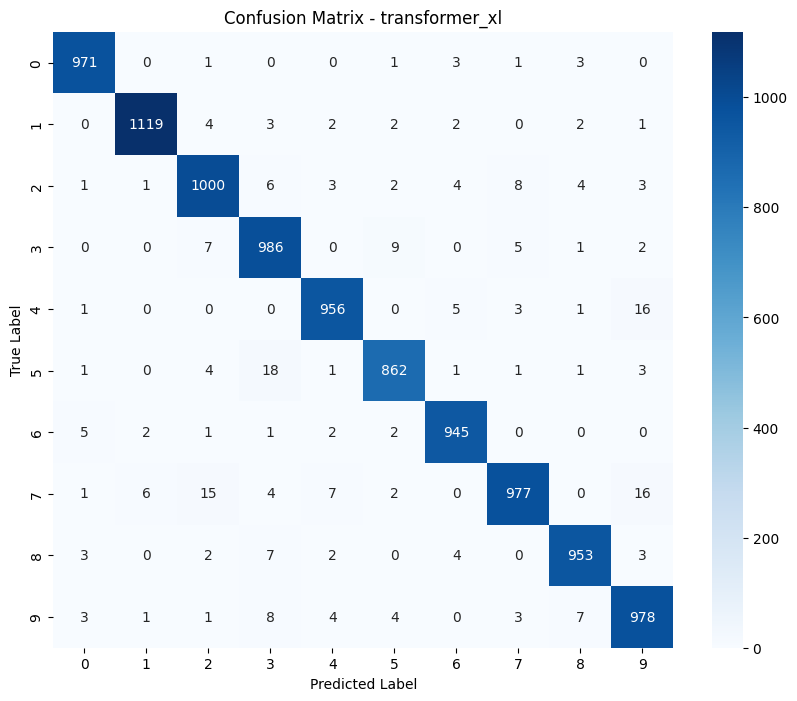


Training LOCAL_ATTENTION model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.3949, Train Acc: 57.95%
Test Loss: 0.4348, Test Acc: 88.99%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.2594, Train Acc: 93.18%
Test Loss: 0.1424, Test Acc: 96.21%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1243, Train Acc: 96.46%
Test Loss: 0.0914, Test Acc: 97.25%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.0833, Train Acc: 97.69%
Test Loss: 0.0730, Test Acc: 97.69%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0664, Train Acc: 98.24%
Test Loss: 0.0689, Test Acc: 97.87%

Final Evaluation for LOCAL_ATTENTION:


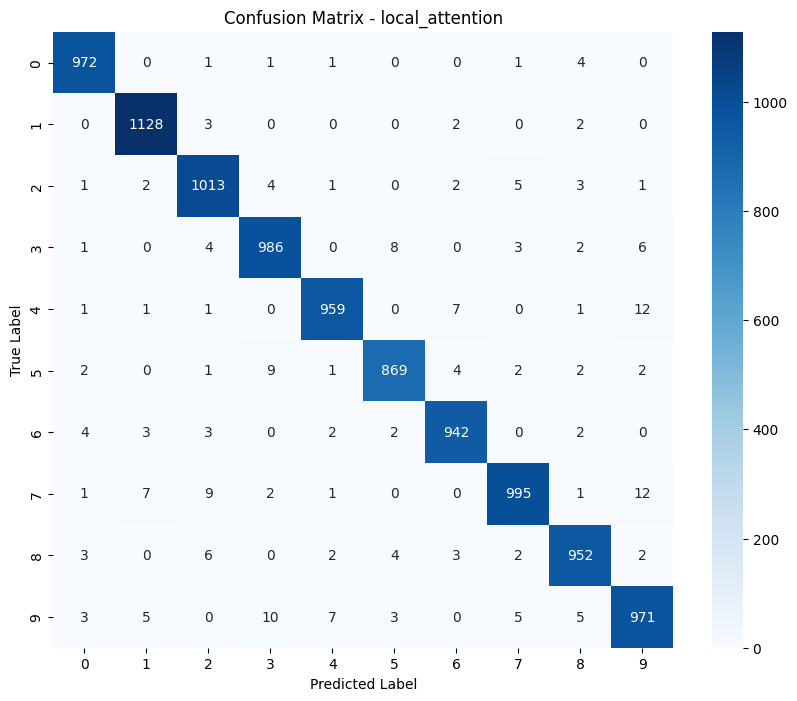


Training PERFORMER model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.5066, Train Acc: 49.18%
Test Loss: 0.7256, Test Acc: 76.74%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.4448, Train Acc: 85.96%
Test Loss: 0.2211, Test Acc: 92.80%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.2066, Train Acc: 93.50%
Test Loss: 0.1492, Test Acc: 95.24%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.1345, Train Acc: 95.77%
Test Loss: 0.1023, Test Acc: 96.65%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.1043, Train Acc: 96.83%
Test Loss: 0.0908, Test Acc: 97.03%

Final Evaluation for PERFORMER:


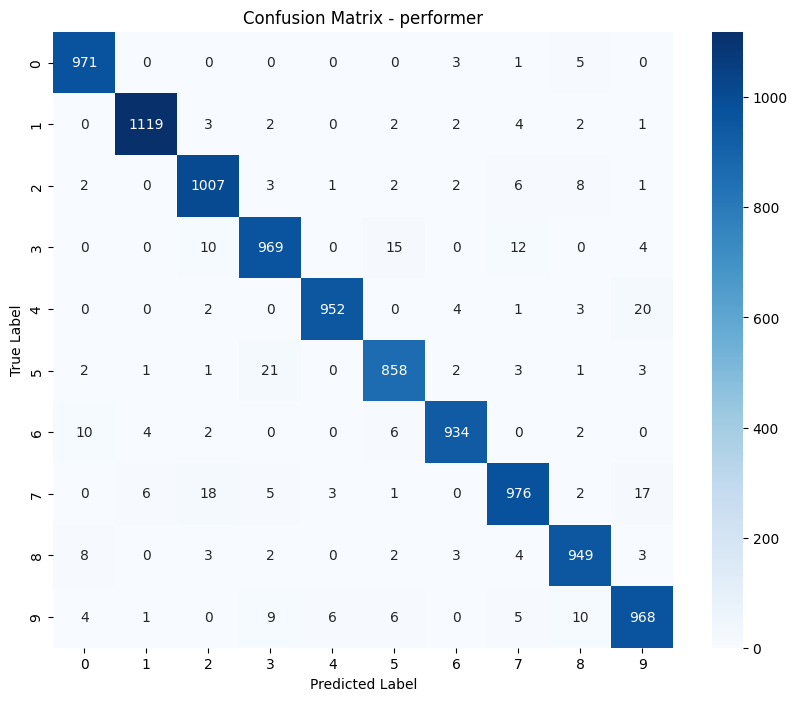


Training MARKOV_XL model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.3932, Train Acc: 52.47%
Test Loss: 0.4072, Test Acc: 87.10%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.2888, Train Acc: 91.18%
Test Loss: 0.1709, Test Acc: 94.52%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1641, Train Acc: 95.07%
Test Loss: 0.1275, Test Acc: 96.00%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.1132, Train Acc: 96.65%
Test Loss: 0.1019, Test Acc: 96.96%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0870, Train Acc: 97.47%
Test Loss: 0.0962, Test Acc: 97.10%

Final Evaluation for MARKOV_XL:


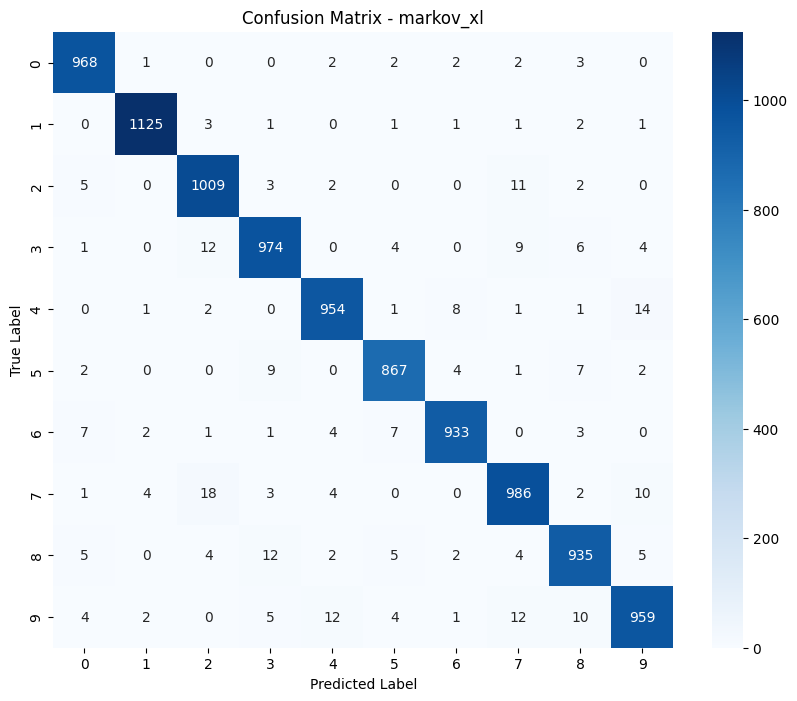


Training MARKOV_LOCAL model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.2795, Train Acc: 57.18%
Test Loss: 0.2923, Test Acc: 90.97%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.2139, Train Acc: 93.50%
Test Loss: 0.1425, Test Acc: 95.69%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1288, Train Acc: 96.20%
Test Loss: 0.1021, Test Acc: 96.88%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.0839, Train Acc: 97.60%
Test Loss: 0.0833, Test Acc: 97.41%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0599, Train Acc: 98.31%
Test Loss: 0.0739, Test Acc: 97.71%

Final Evaluation for MARKOV_LOCAL:


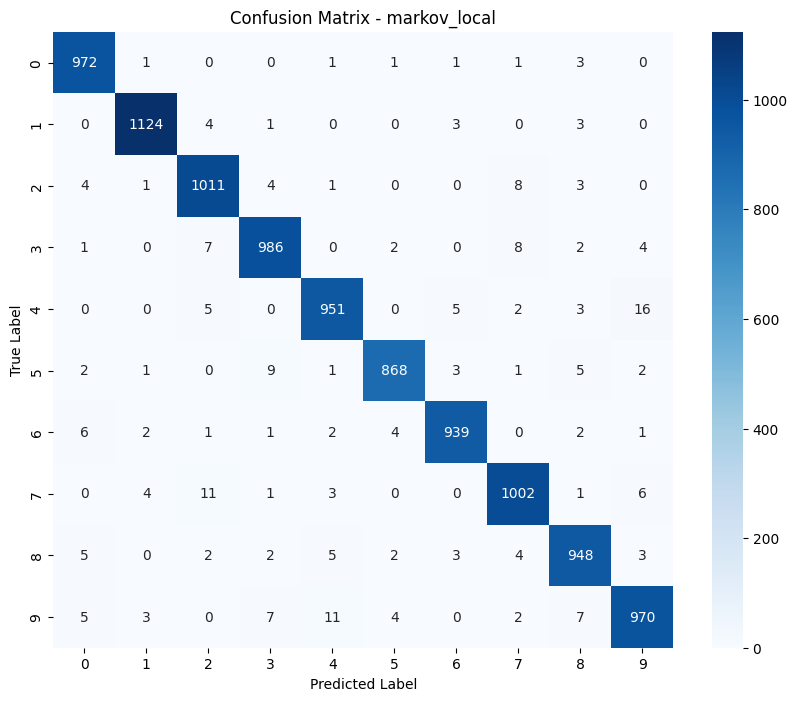


Training MARKOV_PERFORMER model...


C:\Users\Admin\AppData\Local\Temp\ipykernel_464\1258046138.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5:
Train Loss: 1.2416, Train Acc: 58.24%
Test Loss: 0.2959, Test Acc: 91.00%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5:
Train Loss: 0.2311, Train Acc: 93.18%
Test Loss: 0.1499, Test Acc: 95.36%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5:
Train Loss: 0.1460, Train Acc: 95.62%
Test Loss: 0.1118, Test Acc: 96.44%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5:
Train Loss: 0.1011, Train Acc: 96.91%
Test Loss: 0.0931, Test Acc: 97.18%


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5:
Train Loss: 0.0764, Train Acc: 97.73%
Test Loss: 0.0825, Test Acc: 97.43%

Final Evaluation for MARKOV_PERFORMER:


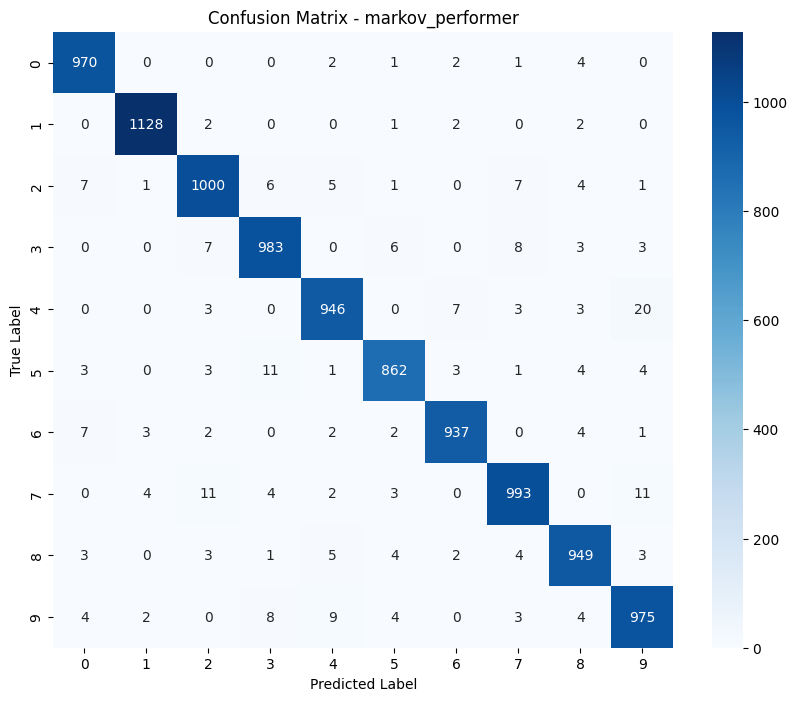

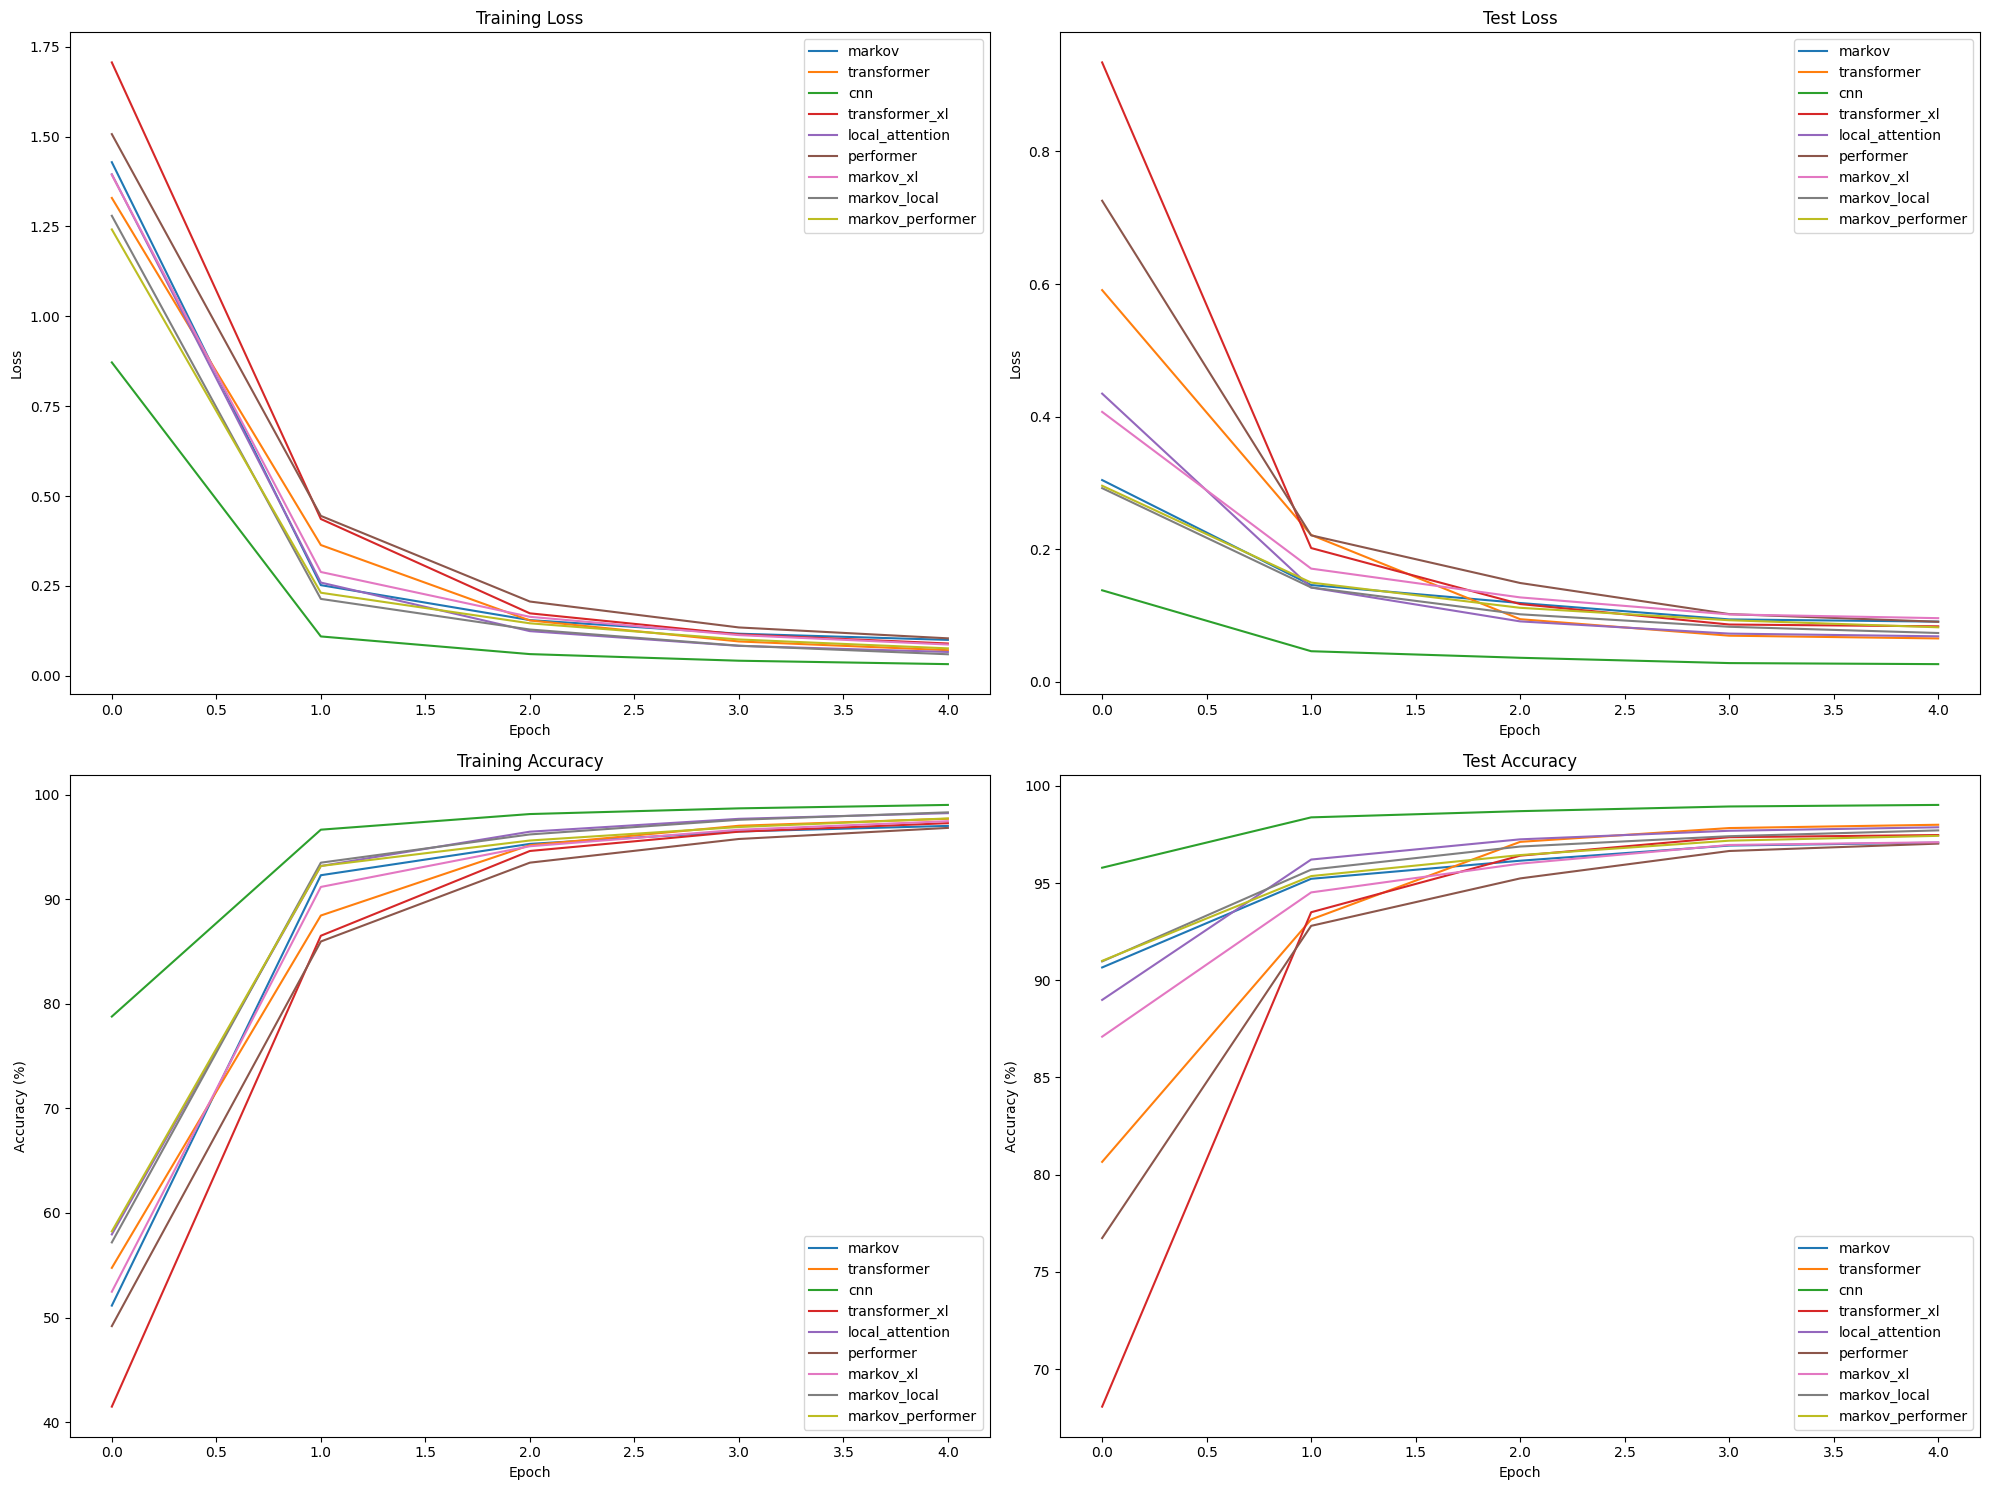

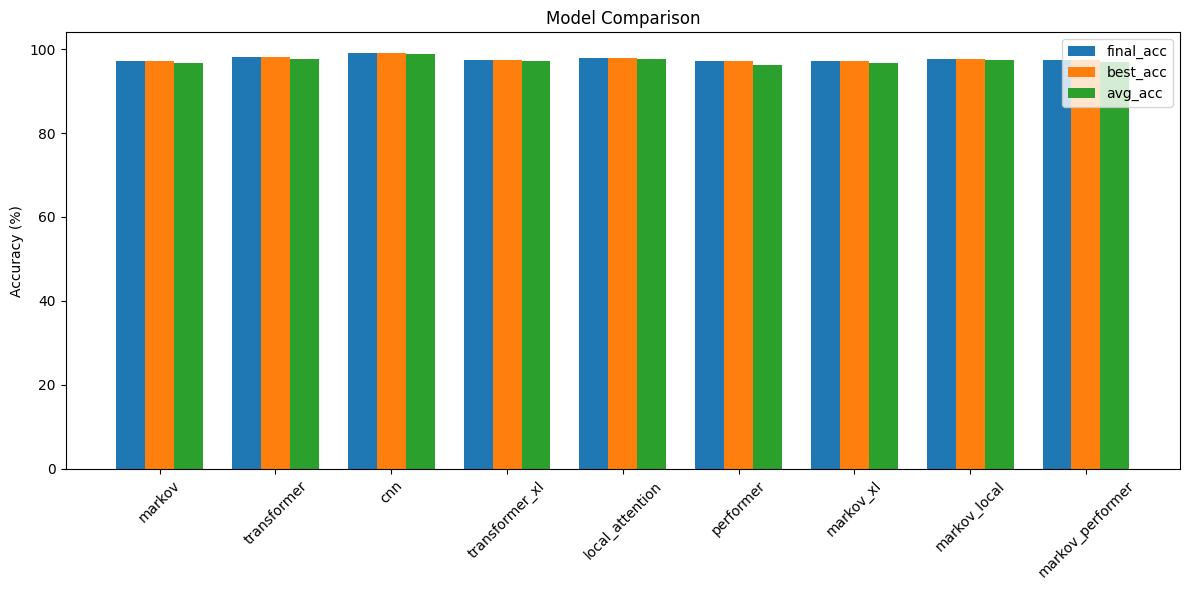


Detailed Results:

MARKOV:
  Final Accuracy: 97.08%
  Best Accuracy: 97.08%
  Average Accuracy (last 3): 96.72%
  Detailed Metrics:
    precision: 0.9706
    recall: 0.9705
    f1: 0.9705
    accuracy: 0.9708

TRANSFORMER:
  Final Accuracy: 98.00%
  Best Accuracy: 98.00%
  Average Accuracy (last 3): 97.65%
  Detailed Metrics:
    precision: 0.9800
    recall: 0.9800
    f1: 0.9799
    accuracy: 0.9800

CNN:
  Final Accuracy: 99.02%
  Best Accuracy: 99.02%
  Average Accuracy (last 3): 98.89%
  Detailed Metrics:
    precision: 0.9902
    recall: 0.9901
    f1: 0.9901
    accuracy: 0.9902

TRANSFORMER_XL:
  Final Accuracy: 97.47%
  Best Accuracy: 97.47%
  Average Accuracy (last 3): 97.08%
  Detailed Metrics:
    precision: 0.9747
    recall: 0.9746
    f1: 0.9746
    accuracy: 0.9747

LOCAL_ATTENTION:
  Final Accuracy: 97.87%
  Best Accuracy: 97.87%
  Average Accuracy (last 3): 97.60%
  Detailed Metrics:
    precision: 0.9787
    recall: 0.9785
    f1: 0.9786
    accuracy: 0.9787

PERFOR

In [11]:
def run_comparative_experiment(sample_size=5000):
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # 配置参数
    config = Config()
    
    # 加载数据
    train_loader, test_loader = load_mnist_data(config.batch_size, sample_size)
    
    # 创建所有模型
    models = {
        'markov': MarkovTransformer(config, num_classes=10),
        'transformer': VanillaTransformer(config, num_classes=10),
        'cnn': CNN(num_classes=10),
        'transformer_xl': TransformerXL(config, num_classes=10),
        'local_attention': LocalAttentionTransformer(config, num_classes=10),
        'performer': Performer(config, num_classes=10),
        'markov_xl': MarkovTransformerXL(config, num_classes=10),
        'markov_local': MarkovLocalAttentionTransformer(config, num_classes=10),
        'markov_performer': MarkovPerformer(config, num_classes=10)
    }
    
    def train_and_evaluate_all_models(models, train_loader, test_loader, config, device):
        results = {}
        history = {name: {'train_loss': [], 'train_acc': [], 
                         'test_loss': [], 'test_acc': []} 
                  for name in models.keys()}
        
        for model_name, model in models.items():
            print(f"\nTraining {model_name.upper()} model...")
            model = model.to(device)
            trainer = ModelTrainer(model, config, device)
            
            for epoch in range(config.max_epochs):
                # 训练
                train_loss, train_acc = trainer.train_epoch(train_loader)
                test_loss, test_acc = trainer.evaluate(test_loader)
                
                # 记录历史
                history[model_name]['train_loss'].append(train_loss)
                history[model_name]['train_acc'].append(train_acc)
                history[model_name]['test_loss'].append(test_loss)
                history[model_name]['test_acc'].append(test_acc)
                
                print(f'Epoch {epoch+1}/{config.max_epochs}:')
                print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
                print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
            
            # 最终评估
            print(f"\nFinal Evaluation for {model_name.upper()}:")
            metrics = evaluate_model(model, test_loader, device, model_name)
            results[model_name] = {
                'final_acc': history[model_name]['test_acc'][-1],
                'best_acc': max(history[model_name]['test_acc']),
                'avg_acc': sum(history[model_name]['test_acc'][-3:]) / 3,
                'metrics': metrics
            }
        
        return results, history
    
    # 训练和评估所有模型
    results, history = train_and_evaluate_all_models(models, train_loader, test_loader, config, device)
    
    # 绘制结果
    def plot_comparative_results(history):
        plt.figure(figsize=(20, 15))
        
        # 训练损失
        plt.subplot(2, 2, 1)
        for model_name in history.keys():
            plt.plot(history[model_name]['train_loss'], label=model_name)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 测试损失
        plt.subplot(2, 2, 2)
        for model_name in history.keys():
            plt.plot(history[model_name]['test_loss'], label=model_name)
        plt.title('Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 训练准确率
        plt.subplot(2, 2, 3)
        for model_name in history.keys():
            plt.plot(history[model_name]['train_acc'], label=model_name)
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        # 测试准确率
        plt.subplot(2, 2, 4)
        for model_name in history.keys():
            plt.plot(history[model_name]['test_acc'], label=model_name)
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    def plot_model_comparison_metrics(results):
        metrics = ['final_acc', 'best_acc', 'avg_acc']
        model_names = list(results.keys())
        
        # 准备数据
        data = {metric: [results[model][metric] for model in model_names] 
                for metric in metrics}
        
        plt.figure(figsize=(12, 6))
        x = np.arange(len(model_names))
        width = 0.25
        
        # 绘制每个指标的柱状图
        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, data[metric], width, label=metric)
        
        plt.ylabel('Accuracy (%)')
        plt.title('Model Comparison')
        plt.xticks(x + width, model_names, rotation=45)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # 绘制结果
    plot_comparative_results(history)
    plot_model_comparison_metrics(results)
    
    # 打印详细结果
    print("\nDetailed Results:")
    for model_name, result in results.items():
        print(f"\n{model_name.upper()}:")
        print(f"  Final Accuracy: {result['final_acc']:.2f}%")
        print(f"  Best Accuracy: {result['best_acc']:.2f}%")
        print(f"  Average Accuracy (last 3): {result['avg_acc']:.2f}%")
        print("  Detailed Metrics:")
        for metric_name, value in result['metrics'].items():
            print(f"    {metric_name}: {value:.4f}")
    
    return results, history

# 运行实验
results, history = run_comparative_experiment(sample_size=60000)

